In [1]:
from icecream import ic
import pandas as pd
from dateutil.relativedelta import relativedelta
# from dhs_preprocessing_functions import *
# from pandarallel import pandarallel
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
print('hi')
%matplotlib inline
# Initialization
# pandarallel.initialize()
import sys
sys.path.append('/home/myuser/prj/code/FoodSecurity/DHS/')
print(sys.path)


from dhs_modelling_functions import final_ds_droping_cols

2024-07-30 16:29:13.978561: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


hi
['/home/myuser', '/home/myuser', '', '/home/myuser/.local/lib/python3.11/site-packages', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '/home/myuser/.local/lib/python3.8/site-packages', '/usr/local/lib/python3.8/dist-packages', '/usr/lib/python3/dist-packages', '/home/myuser/.local/lib/python3.8/site-packages/setuptools/_vendor', '/home/myuser/prj/code/FoodSecurity/DHS/']


In [2]:

input_dir = "/mnt/datadisk/data/Projects/water/inputs/"
# min_version = 3
overwrite_pqt = True
dataset_type = 'HR'  #, 'BR', 'CR', 'HW', 'IR', 'KR', 'MR', 'PR', 'AR'] ??['AN', 'FC, 'FP', 'HW', 'PV', 'SC'] < 25 surveys
urban_rural_all_mode = 'all' # 'all', 'U', 'R'
group_by_col = 'adm2_gaul'
out_f = f"{input_dir}5_grouped_df_V3_{dataset_type}_{group_by_col}_joined_with_ipc_{urban_rural_all_mode}.pkl"

# Scale options
scale_numerical_data = False
scale_all_data = True
leave_out_encodings = False
zero_one_scale_categorical = False


in_f = f"{input_dir}5_grouped_df_V3_{dataset_type}_{group_by_col}_joined_with_ipc_{urban_rural_all_mode}.pkl"

In [3]:
input_df = pd.read_pickle(in_f)
for col in input_df.columns:
    print(col)
input_df[['DHS Cat; URBAN_RURA: R', 'DHS Cat; URBAN_RURA: NaN']].value_counts(dropna=False)

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/datadisk/data/Projects/water/inputs/5_grouped_df_V3_HR_adm2_gaul_joined_with_ipc_all.pkl'

In [ ]:
drop_agriculture = False
# if urban_rural_all_mode == 'U':
#     drop_agriculture = True
df = final_ds_droping_cols(input_df, drop_meta=True, drop_food_help=True, drop_perc=40,
                           retain_month=False, drop_highly_correlated_cols=False, drop_region=True, 
                 drop_data_sets=['Meta one-hot encoding', 'Meta frequency encoding'], 
                 use_NAN_amount_and_replace_NANs_in_categorical=False, drop_agricultural_cols=drop_agriculture, 
                 drop_below_version=False, numerical_data=['mean'], retain_adm=False, 
                 retain_GEID_init=False, verbose=3)
#'Meta one-hot encoding', 'Meta frequency encoding'
df.to_csv(f"{input_dir}Prefiltered_grouped_df_V3_{dataset_type}_{group_by_col}_{urban_rural_all_mode}_minimal_ds.csv")

Dropped Meta one-hot encoding; data: ['Meta one-hot encoding; adm0_gaul: Angola', 'Meta one-hot encoding; adm0_gaul: Benin', 'Meta one-hot encoding; adm0_gaul: Burkina Faso', 'Meta one-hot encoding; adm0_gaul: Burundi', 'Meta one-hot encoding; adm0_gaul: Cameroon', 'Meta one-hot encoding; adm0_gaul: Central African Republic', 'Meta one-hot encoding; adm0_gaul: Chad', 'Meta one-hot encoding; adm0_gaul: Comoros', "Meta one-hot encoding; adm0_gaul: Côte d'Ivoire", 'Meta one-hot encoding; adm0_gaul: Democratic Republic of the Congo', 'Meta one-hot encoding; adm0_gaul: Egypt', 'Meta one-hot encoding; adm0_gaul: Ethiopia', 'Meta one-hot encoding; adm0_gaul: Gabon', 'Meta one-hot encoding; adm0_gaul: Gambia', 'Meta one-hot encoding; adm0_gaul: Ghana', 'Meta one-hot encoding; adm0_gaul: Guinea', 'Meta one-hot encoding; adm0_gaul: Kenya', 'Meta one-hot encoding; adm0_gaul: Lesotho', 'Meta one-hot encoding; adm0_gaul: Liberia', 'Meta one-hot encoding; adm0_gaul: Madagascar', 'Meta one-hot encodi

In [ ]:
for col in df.columns:
    print(col)

Meta; GEID_init
Meta; adm0_gaul
Meta; year
DHS Num; number of household members: mean
DHS Num; owns sheep: mean
DHS Num; number of eligible children for height and weight: mean
DHS Num; total adults measured: mean
DHS Num; number of mosquito bed nets: mean
DHS Num; cluster altitude in meters: mean
DHS Num; number of eligible women in household: mean
DHS Num; number of children 5 and under (de jure): mean
DHS Num; number of households sharing toilet: mean
DHS Num; hectares of agricultural land (1 decimal): mean
DHS Num; number of rooms used for sleeping: mean
DHS Num; owns goats: mean
DHS Num; owns horses/ donkeys/ mules: mean
DHS Num; time to get to water source (minutes): mean
DHS Num; owns cows/ bulls: mean
DHS Num; owns chickens/poultry: mean
DHS Cat; type of place of residence: rural
DHS Cat; source of drinking water: other
DHS Cat; source of drinking water: piped into dwelling
DHS Cat; source of drinking water: piped to neighbor
DHS Cat; source of drinking water: piped to yard/plo

In [ ]:
# Define RMSE
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 


In [ ]:
label_df = df[[c for c in df.columns if 'FS; IPC' in c]]
input_df2 = df.drop(columns=[c for c in df.columns if 'FS; IPC' in c])
num_cols = [c for c in input_df2.columns if 'DHS Num;' in c or c == 'Meta; Year' or c == 'Meta; Month']

label_cols = [c for c in df.columns if 'FS; IPC' in c]
scaler_l = []
history_l = []
y_test_l = []
y_pred_l = []
model_l = []
amount_inputs = []
amount_cols = []

for nr, col in enumerate(label_cols):

    print(nr, col, len(df[col]))
    labels = df[col]
    labels = labels.dropna()
    # labels = labels[labels < 4]
    labels_ind = labels.index
    # scale the labels
    scaler = StandardScaler()
    labels = scaler.fit_transform(labels.values.reshape(-1, 1))
    labels = pd.Series(labels.flatten(), index=labels_ind)
    input_df = input_df2.loc[labels.index]

    #drop NaNs
    input_df = input_df.dropna(axis=0)
    input_ind = input_df.index
    labels = labels.loc[input_ind]
    print('lens', len(labels), len(input_df))
    print('cols', len(input_df.columns))
    if len(input_df) < 100:
        continue
    
    amount_cols.append(len(input_df.columns))
    assert(labels.index.equals(input_df.index))
    amount_inputs.append(len(input_df))
    scaler_l.append(scaler)

    scaler2 = StandardScaler()    
    if scale_all_data:
        if leave_out_encodings:
            cols = [c for c in input_df.columns if 'Meta one-hot encoding;' not in c and 
                    'Meta frequency encoding;' not in c]
            input_df[cols] = scaler2.fit_transform(input_df[cols])
        else:
            input_df[input_df.columns] = scaler2.fit_transform(input_df)
    else:
        if scale_numerical_data:
            input_df[num_cols] = scaler2.fit_transform(input_df[num_cols])
        
        if zero_one_scale_categorical:
            scaler3 = MinMaxScaler()
            cols = [c for c in input_df.columns if 'DHS Cat;' in c]
            input_df[cols] = scaler3.fit_transform(input_df[cols])
    
    # input_df.to_csv(f"{input_dir}Prefiltered_normalized_grouped_df_V3_{dataset_type}_{group_by_col}_{urban_rural_all_mode}_m_{col}.csv")
        
        
        
    # assert labels.index.equals(input_df.index)
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(input_df, labels, test_size=0.15, random_state=2)

    # Further split the training data into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2)  # 0.25 x 0.8 = 0.2

    X_train = X_train.astype('float32')
    y_train = y_train.astype('float32')
    X_val = X_val.astype('float32')
    y_val = y_val.astype('float32')
    X_test = X_test.astype('float32')
    y_test = y_test.astype('float32')
    
    # Define the model
    model = Sequential()
    model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='linear'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=[root_mean_squared_error])

    # Define the ModelCheckpoint callback
    checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val), callbacks=[checkpoint])
    history_l.append(history)
    
    # Load the best model
    model.load_weights('best_model.h5')
    
    model_l.append(model)
    # Evaluate the model on the test set
    test_loss, test_rmse = model.evaluate(X_test, y_test)
    print(f'Test Loss: {test_loss}')
    print(f'Test RMSE: {test_rmse}')

    # Predict on the test set
    y_pred = model.predict(X_test)
    y_test_l.append(y_test)
    y_pred_l.append(y_pred)

0 FS; IPC: 0-2y: mean 15252
lens 770 770
cols 105


ValueError: could not convert string to float: 'CMGE71FL'

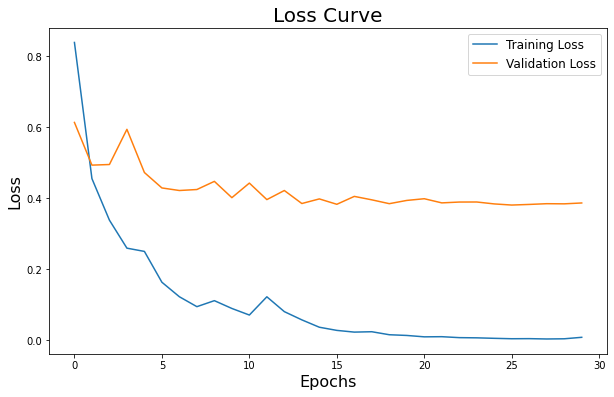

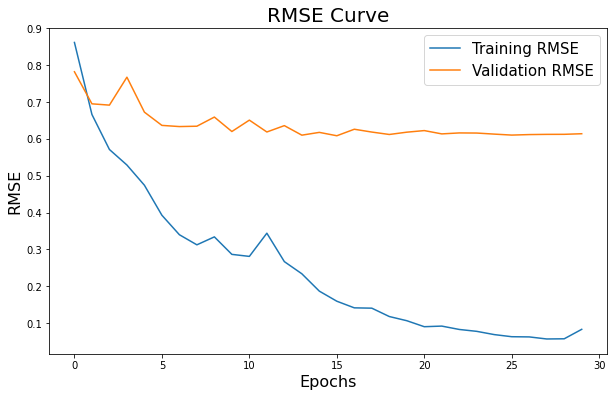

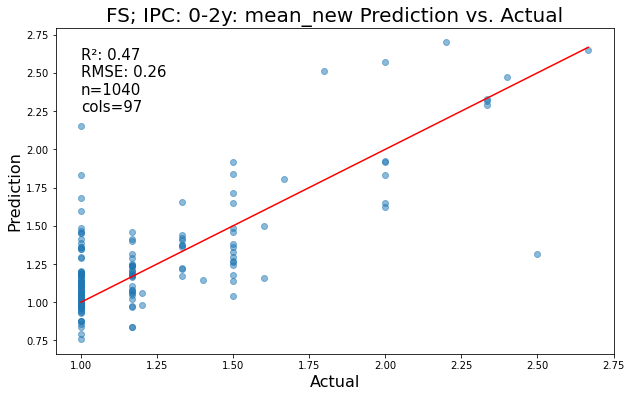

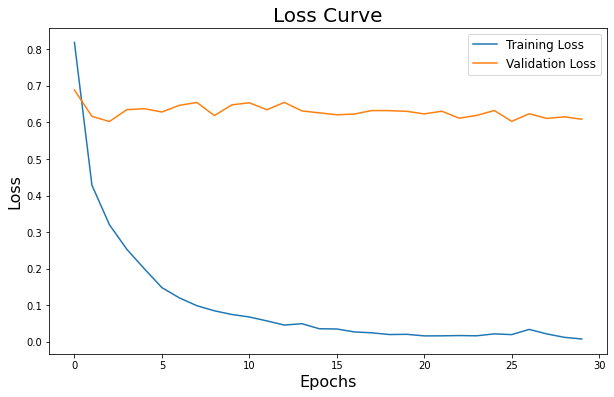

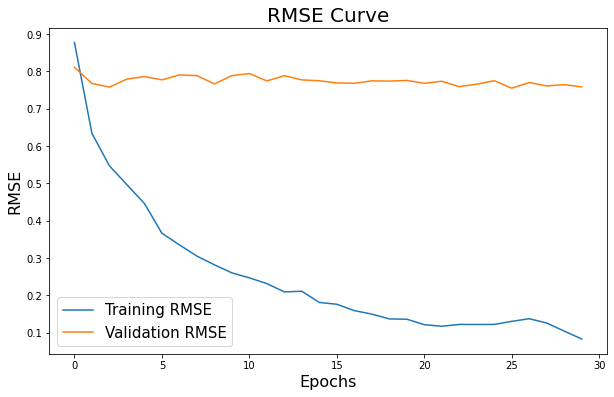

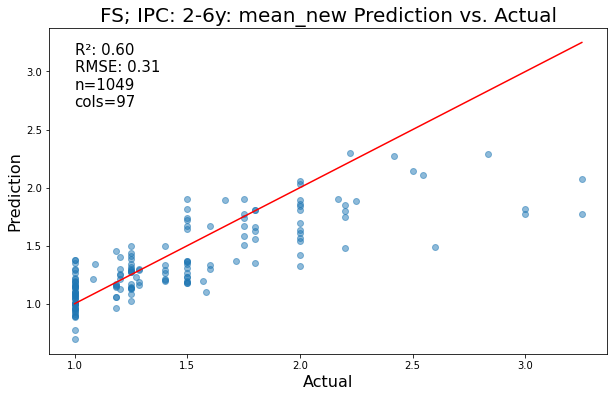

In [ ]:
summary_dic = {}
for name, history, scaler, y_test, y_pred, amount_input, amount_col in zip(label_cols, history_l, scaler_l, y_test_l, y_pred_l, amount_inputs, amount_cols):
    # Loss curve
    name += '_new'
    plt.figure(figsize=(10, 6), facecolor='white')
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve', fontsize=20)
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(fontsize=12)
    plt.savefig(f"{input_dir}loss_curve_{name}.png")

    plt.figure(figsize=(10, 6), facecolor='white')
    plt.plot(history.history['root_mean_squared_error'], label='Training RMSE')
    plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
    plt.title('RMSE Curve', fontsize=20)
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('RMSE', fontsize=16)
    plt.legend(fontsize=15)
    plt.savefig(f"{input_dir}rmse_curve_{name}.png")

    y_pred = scaler.inverse_transform(y_pred)
    y_test = scaler.inverse_transform(y_test.to_numpy().reshape(-1, 1))
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    summary_dic[name] = [round(r2, 3), round(rmse, 3), amount_input, amount_col, y_test.std()]

    plt.figure(figsize=(10, 6), facecolor='white')
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel('Actual', fontsize=16)
    plt.ylabel('Prediction', fontsize=16)
    plt.title(f'{name} Prediction vs. Actual', fontsize=20)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
    plt.text(min(y_test), max(y_test), f'R²: {r2:.2f}\nRMSE: {rmse:.2f}\nn={amount_input}\ncols={amount_col}', verticalalignment='top', horizontalalignment='left', backgroundcolor='white', fontsize=15)
    plt.savefig(f"{input_dir}Scatterplot_{name.replace(':', '')}.png")
    

In [ ]:
summary_df = pd.DataFrame(summary_dic).T
summary_df.columns = ['R²', 'RMSE', 'n', 'input cols', 'std']
summary_df

,R²,RMSE,n,input cols,std
FS; IPC: 0-2y: mean_new,0.466,0.260,1040.0,97.0,0.355694
FS; IPC: 2-6y: mean_new,0.598,0.314,1049.0,97.0,0.494448


In [ ]:
asd
for model, name, scaler in zip(model_l, label_cols, scaler_l):
    print('MZGE7AFL' in meta_df['GEID_init'].values)
    meta_ind = meta_df[meta_df['GEID_init'] == 'MZGE7AFL'].index
    input_df = input_df2.loc[meta_ind]
    # Predict on the test set
    y_pred = model.predict(input_df)

    # Inverse transform y_pred
    y_pred_actual = scaler.inverse_transform(y_pred)
    # Convert y_pred_actual to a series
    y_pred_actual_series = pd.Series(y_pred_actual.flatten(), index=meta_ind)

    moz_df = pd.concat([meta_df.loc[meta_ind], pd.DataFrame(y_pred_actual_series, columns=[name])], axis=1)
    moz_df.to_csv(f"{input_dir}predicted_{name}.csv")

NameError: name 'asd' is not defined

In [ ]:
meta_df['GEID_init'].value_counts().head(50)

NameError: name 'meta_df' is not defined